# Customer Segmentation using PySpark

In [2]:
# !pip install pyspark

In [3]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import * # to create a dataframe of a specific type
from pyspark.sql.functions import * # importig SQL functions
from pyspark.sql.window import Window

In [4]:
spark = SparkSession.builder.getOrCreate()
spark

In [5]:
type(spark)

pyspark.sql.session.SparkSession

In [6]:
data = spark.read.csv("Data.csv", inferSchema=True, header=True)

In [7]:
data.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- FlightCode: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [8]:
type(data)

pyspark.sql.dataframe.DataFrame

In [9]:
data.show(5)

+---------+----------+--------+--------------+---------+----------+--------------+
|InvoiceNo|FlightCode|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+----------+--------+--------------+---------+----------+--------------+
|   536365|    85123A|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|     71053|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    84406B|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|    84029G|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    84029E|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+----------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



In [10]:
data.toPandas().shape

(541909, 7)

In [11]:
data.describe().show()

+-------+------------------+------------------+------------------+---------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|        FlightCode|          Quantity|    InvoiceDate|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+------------------+---------------+-----------------+------------------+-----------+
|  count|            541909|            541909|            541909|         541909|           541909|            406829|     541909|
|   mean|  559965.752026781|27623.240210938104|  9.55224954743324|           null|4.611113626089845|15287.690570239585|       null|
| stddev|13428.417280795411|16799.737628427683|218.08115785023435|           null|96.75985306117933|1713.6003033215986|       null|
|    min|            536365|             10002|            -80995|1/10/2011 10:04|        -11062.06|             12346|  Australia|
|    max|           C581569|                 m|             80995|  9/9/2011

In [12]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---------+----------+--------+-----------+---------+----------+-------+
|InvoiceNo|FlightCode|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+----------+--------+-----------+---------+----------+-------+
|        0|         0|       0|          0|        0|    135080|      0|
+---------+----------+--------+-----------+---------+----------+-------+



In [13]:
data.groupBy("Country").count().sort("count", ascending=False).show(10)

+--------------+------+
|       Country| count|
+--------------+------+
|United Kingdom|495478|
|       Germany|  9495|
|        France|  8557|
|          EIRE|  8196|
|         Spain|  2533|
|   Netherlands|  2371|
|       Belgium|  2069|
|   Switzerland|  2002|
|      Portugal|  1519|
|     Australia|  1259|
+--------------+------+
only showing top 10 rows



In [14]:
# Customer distribution by country

rtl_data = data["Country", "CustomerID"].distinct().groupBy("Country").agg(count
          ("CustomerID").alias("Count")).withColumn('Total', sum('Count').over
          (Window.partitionBy())).withColumn('%', (col('Count')/col('Total'))*100).sort("Count", ascending=False)
rtl_data.show(5)

+--------------+-----+-----+------------------+
|       Country|Count|Total|                 %|
+--------------+-----+-----+------------------+
|United Kingdom| 3950| 4380| 90.18264840182648|
|       Germany|   95| 4380|2.1689497716894977|
|        France|   87| 4380|1.9863013698630139|
|         Spain|   31| 4380|0.7077625570776256|
|       Belgium|   25| 4380|0.5707762557077625|
+--------------+-----+-----+------------------+
only showing top 5 rows



In [15]:
# customers from UK
rtl_data = data.filter(col("Country") == "United Kingdom")

rtl_data = rtl_data.filter(col("CustomerID").isNotNull())

print(rtl_data.toPandas().shape)
rtl_data.show(5)
rtl_data.describe().show()

(361878, 7)
+---------+----------+--------+--------------+---------+----------+--------------+
|InvoiceNo|FlightCode|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+----------+--------+--------------+---------+----------+--------------+
|   536365|    85123A|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|     71053|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    84406B|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|    84029G|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    84029E|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+----------+--------+--------------+---------+----------+--------------+
only showing top 5 rows

+-------+-----------------+------------------+------------------+---------------+-----------------+------------------+--------------+
|summary|        InvoiceNo|        FlightCode|          Quantity|    InvoiceDate| 

In [16]:
rtl_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in rtl_data.columns]).show()

+---------+----------+--------+-----------+---------+----------+-------+
|InvoiceNo|FlightCode|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+----------+--------+-----------+---------+----------+-------+
|        0|         0|       0|          0|        0|         0|      0|
+---------+----------+--------+-----------+---------+----------+-------+



In [17]:
rtl_data.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- FlightCode: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [18]:
rtl_data.describe().show()

+-------+-----------------+------------------+------------------+---------------+-----------------+------------------+--------------+
|summary|        InvoiceNo|        FlightCode|          Quantity|    InvoiceDate|        UnitPrice|        CustomerID|       Country|
+-------+-----------------+------------------+------------------+---------------+-----------------+------------------+--------------+
|  count|           361878|            361878|            361878|         361878|           361878|            361878|        361878|
|   mean|  560672.61234108|27661.093939094237|11.077028722387103|           null|3.256006897352265|15547.871368251179|          null|
| stddev|13168.98861604077|16738.542340466625| 263.1292655989742|           null|70.65473116893888|1594.4025904479602|          null|
|    min|           536365|             10002|            -80995|1/10/2011 10:32|              0.0|             12346|United Kingdom|
|    max|          C581569|              POST|             809

In [19]:
# To remove negative Quantities
rtl_data = rtl_data.filter(col("Quantity") > 0)
# Total Amount column
rtl_data = rtl_data.withColumn("TotalAmount", round(col("Quantity") * col("UnitPrice")))

In [20]:
rtl_data.limit(5).toPandas()

,InvoiceNo,FlightCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,6,12/1/2010 8:26,2.55,17850,United Kingdom,15.0
1,536365,71053,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.0
2,536365,84406B,8,12/1/2010 8:26,2.75,17850,United Kingdom,22.0
3,536365,84029G,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.0
4,536365,84029E,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.0


### Filtering Data

In [21]:
rtl_data.filter(rtl_data.Quantity > 50000).show()

+---------+----------+--------+---------------+---------+----------+--------------+-----------+
|InvoiceNo|FlightCode|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|TotalAmount|
+---------+----------+--------+---------------+---------+----------+--------------+-----------+
|   541431|     23166|   74215|1/18/2011 10:01|     1.04|     12346|United Kingdom|    77184.0|
|   581483|     23843|   80995| 12/9/2011 9:15|     2.08|     16446|United Kingdom|   168470.0|
+---------+----------+--------+---------------+---------+----------+--------------+-----------+



In [22]:
df = rtl_data.toPandas()

In [23]:
print(df.InvoiceDate.min())
print(df.InvoiceDate.max())

1/10/2011 10:32
9/9/2011 9:52


In [24]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [25]:
# calculating the monetary values
monetary =df.groupby("CustomerID").TotalAmount.sum()
monetary = monetary.reset_index() 
monetary.head()

,CustomerID,TotalAmount
0,12346,77184.0
1,12747,4207.0
2,12748,33956.0
3,12749,4115.0
4,12820,946.0


In [26]:
# calculating the frequency values
frequency=df.groupby("CustomerID").InvoiceNo.count()
frequency = frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346,1
1,12747,103
2,12748,4596
3,12749,199
4,12820,59


In [27]:
#calculating our recency value
LastDate=df.InvoiceDate.max() #calculating the last date of InvoiceDate
LastDate = LastDate + pd.DateOffset(days=1)
df["Diff"] = LastDate - df.InvoiceDate
recency = df.groupby("CustomerID").Diff.min()
recency = recency.reset_index()
recency.head()

,CustomerID,Diff
0,12346,326 days 02:48:00
1,12747,2 days 22:15:00
2,12748,1 days 00:29:00
3,12749,4 days 02:53:00
4,12820,3 days 21:37:00


In [28]:
rmf = monetary.merge(frequency, on = "CustomerID")
rmf = rmf.merge(recency, on = "CustomerID")
rmf.columns = ["CustomerID", "Monetary", "Frequence", "Recency"]
RMF1 = rmf.drop("CustomerID",axis =1) #dropping customer id and storing it into RMF1
RMF1.Recency = RMF1.Recency.dt.days
RMF1.head()

,Monetary,Frequence,Recency
0,77184.0,1,326
1,4207.0,103,2
2,33956.0,4596,1
3,4115.0,199,4
4,946.0,59,3


In [29]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

In [30]:
rfm_numbers = spark.read.csv("customer_rfm_numbers.csv", inferSchema=True, header=True)

In [31]:
rfm_numbers.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15619|     11|        1|   337.0|
|     17389|      1|       34| 31852.0|
|     14450|    181|        3|   485.0|
|     15727|     17|        7|  5220.0|
|     15790|     11|        1|   225.0|
+----------+-------+---------+--------+
only showing top 5 rows



In [32]:
rfm_numbers_df = rfm_numbers.toPandas()

C:\Users\ASHUTOSH ROKADE\AppData\Local\Temp\ipykernel_1300\4156693613.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_numbers_df['Recency'])
C:\Users\ASHUTOSH ROKADE\AppData\Local\Temp\ipykernel_1300\4156693613.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_numbers_df['Frequency

<AxesSubplot: xlabel='Monetary', ylabel='Density'>

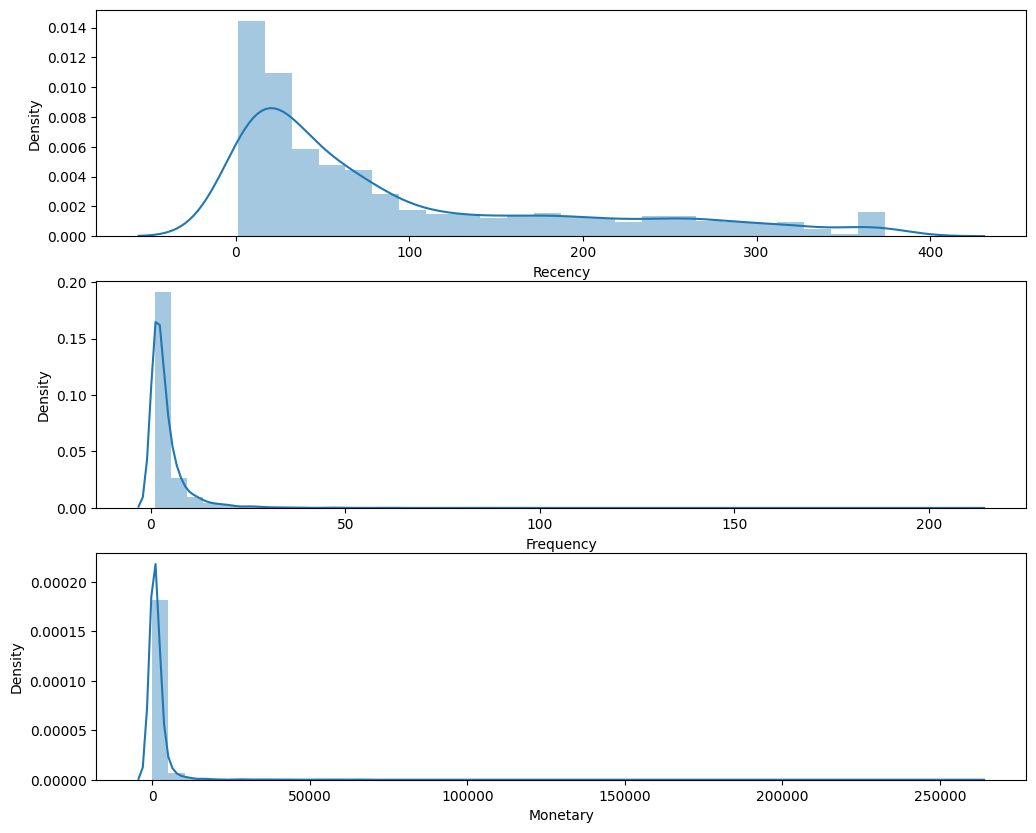

In [33]:
import seaborn as sns
plt.figure(figsize=(12,10))
# Plot distribution of recency
plt.subplot(3, 1, 1)
sns.distplot(rfm_numbers_df['Recency'])
# Plot distribution of frequency
plt.subplot(3, 1, 2)
sns.distplot(rfm_numbers_df['Frequency'])
# Plot distribution of monetary
plt.subplot(3, 1, 3)
sns.distplot(rfm_numbers_df['Monetary'])

In [34]:
# remove zero and negative numbers
rfm_data = (rfm_numbers.withColumn("Monetary", when(col("Monetary") <= 0, 1).otherwise(col("Monetary"))))

In [35]:
features = rfm_data.columns[1:]

In [36]:
rfm_data.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15619|     11|        1|   337.0|
|     17389|      1|       34| 31852.0|
|     14450|    181|        3|   485.0|
|     15727|     17|        7|  5220.0|
|     15790|     11|        1|   225.0|
+----------+-------+---------+--------+
only showing top 5 rows



In [37]:
# vectorize all features
assembler = VectorAssembler(inputCols=features, outputCol="rfm_features")
assembled_data = assembler.transform(rfm_data)
assembled_data = assembled_data.select('CustomerID', 'rfm_features')
assembled_data.show(5)

+----------+------------------+
|CustomerID|      rfm_features|
+----------+------------------+
|     15619|  [11.0,1.0,337.0]|
|     17389|[1.0,34.0,31852.0]|
|     14450| [181.0,3.0,485.0]|
|     15727| [17.0,7.0,5220.0]|
|     15790|  [11.0,1.0,225.0]|
+----------+------------------+
only showing top 5 rows



In [38]:
# Standardization 
scaler = StandardScaler(inputCol='rfm_features', outputCol='rfm_standardized')
data_scale = scaler.fit(assembled_data)
scaled_data = data_scale.transform(assembled_data)
scaled_data.show(5)

+----------+------------------+--------------------+
|CustomerID|      rfm_features|    rfm_standardized|
+----------+------------------+--------------------+
|     15619|  [11.0,1.0,337.0]|[0.11052107132513...|
|     17389|[1.0,34.0,31852.0]|[0.01004737012046...|
|     14450| [181.0,3.0,485.0]|[1.81857399180447...|
|     15727| [17.0,7.0,5220.0]|[0.17080529204793...|
|     15790|  [11.0,1.0,225.0]|[0.11052107132513...|
+----------+------------------+--------------------+
only showing top 5 rows



### Using the Elbow Method to find the optimal number of clusters

In [39]:
costs = np.zeros(10)
# Apply k-means with different value of k
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('rfm_standardized')
    model = kmeans.fit(scaled_data)
    costs[k] = model.summary.trainingCost
    print(costs[k])

8432.530690405676
6975.131002875297
3794.3836574461575
3162.975504627705
2742.220293503049
2000.0247958095274
1607.2008443831562
1435.362995672892


Text(0.5, 1.0, 'Elbow Curve')

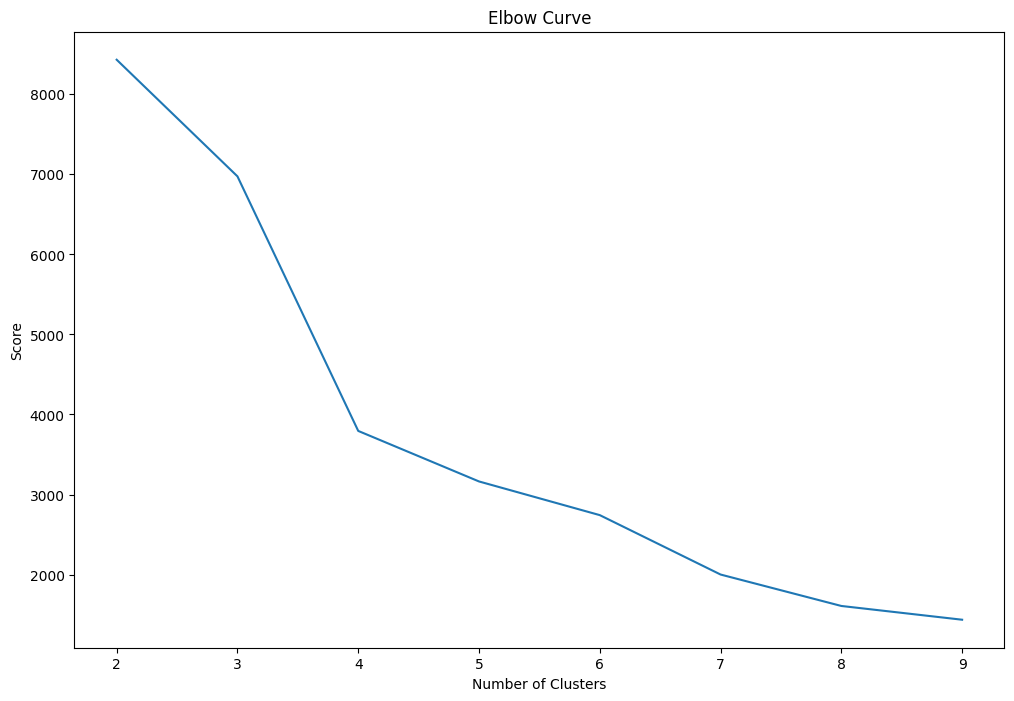

In [40]:
# Plot the cost
df_cost = pd.DataFrame(costs[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

fig, ax = plt.subplots(1, 1, figsize =(12, 8))
ax.plot(df_cost.cluster, df_cost.cost)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Score')
ax.set_title('Elbow Curve')

In [41]:
df_cost

,cluster,cost
0,2,8432.530690
1,3,6975.131003
2,4,3794.383657
3,5,3162.975505
4,6,2742.220294
5,7,2000.024796
6,8,1607.200844
7,9,1435.362996


### K Means Clustering

In [43]:
k_means = KMeans(featuresCol='rfm_standardized', k=4)
model = k_means.fit(scaled_data)
predictions = model.transform(scaled_data)

result = predictions.select('CustomerID', 'prediction')

In [ ]:
result.show(5)

+----------+----------+
|CustomerID|prediction|
+----------+----------+
|     15619|         0|
|     17389|         3|
|     14450|         1|
|     15727|         0|
|     15790|         0|
+----------+----------+
only showing top 5 rows



In [ ]:
rfm_score = spark.read.csv('retail_loyalty_rfm.csv', inferSchema=True, header=True)
rfm_score = rfm_score.select("CustomerID", "Recency", "Frequency", "Monetary", "Loyalty")
rfm_score.show(5)

+----------+-------+---------+--------+--------+
|CustomerID|Recency|Frequency|Monetary| Loyalty|
+----------+-------+---------+--------+--------+
|     16678|      3|      163|  3111.0|Platinum|
|     17735|      3|      690| 13207.0|Platinum|
|     17139|     16|      478| 10750.0|Platinum|
|     13408|      2|      478| 28127.0|Platinum|
|     17389|      1|      213| 31852.0|Platinum|
+----------+-------+---------+--------+--------+
only showing top 5 rows



In [ ]:
combined_result = result.join(rfm_score, on='CustomerID', how='inner')

In [ ]:
result = combined_result.toPandas()

In [ ]:
import seaborn as sns

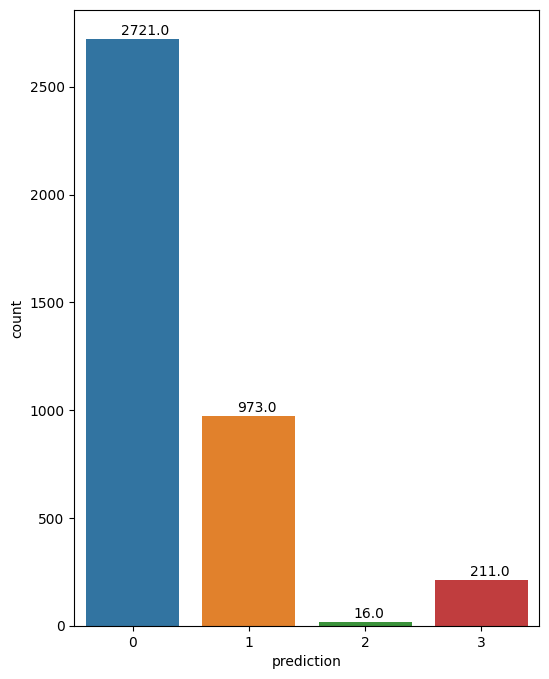

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="prediction", data=result)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 20))

<AxesSubplot: xlabel='prediction', ylabel='Monetary'>

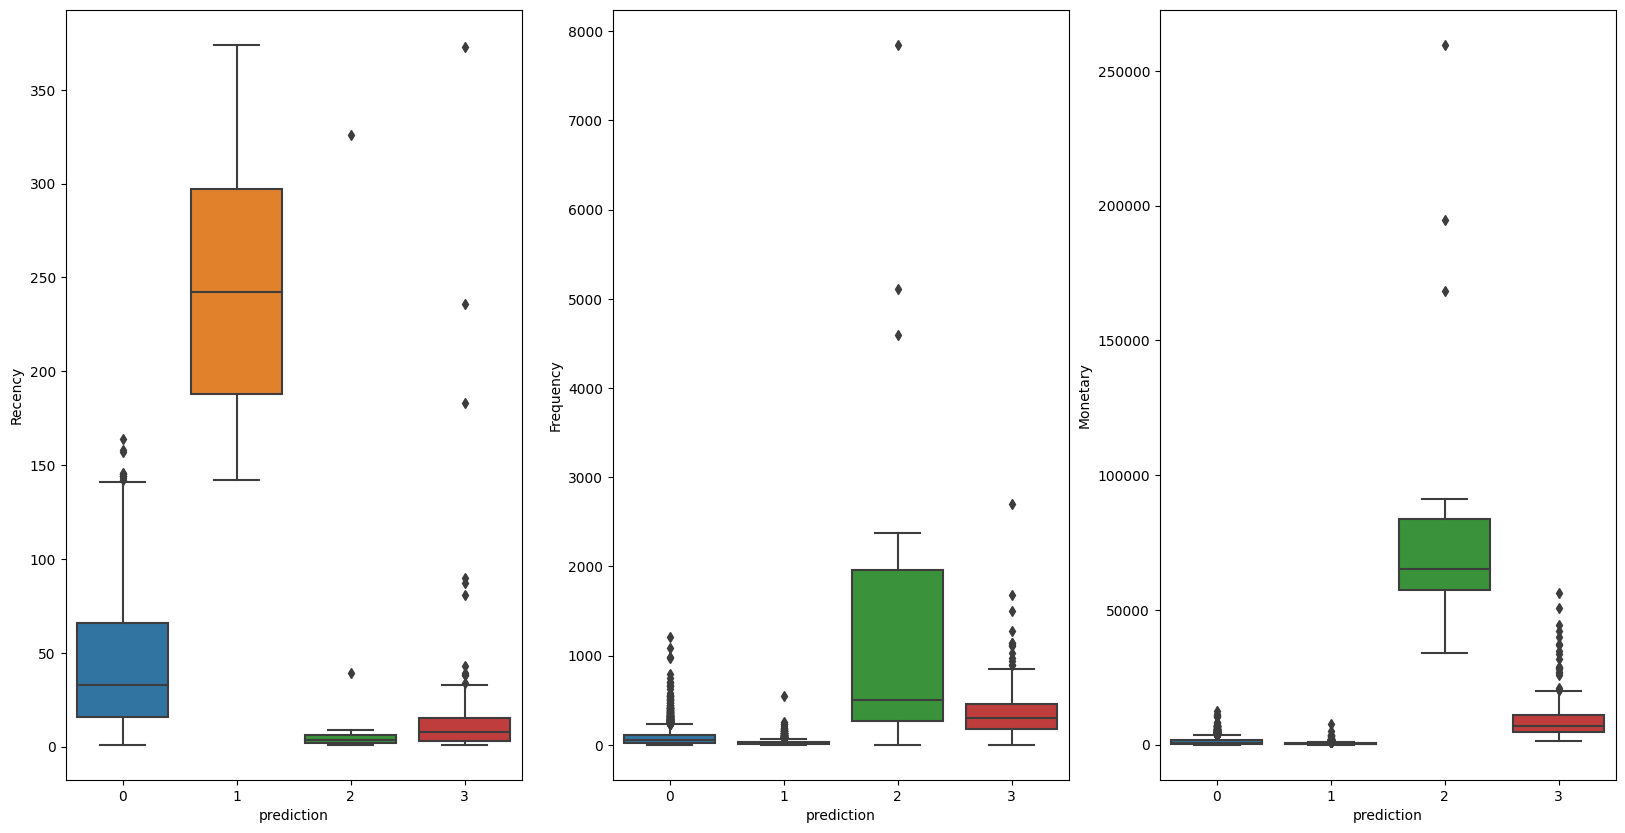

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.boxplot(x='prediction', y='Recency', data=result, ax=ax[0])
sns.boxplot(x='prediction', y='Frequency', data=result, ax=ax[1])
sns.boxplot(x='prediction', y='Monetary', data=result, ax=ax[2])